# 17 Category Flower Dataset

Classification


In [6]:
#Import the Necessary Packages
import tarfile
import urllib
import os

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Set up GPU (If Available)

In [7]:
#Set the device as CUDA (GPU), if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device
print(device)

cpu


## Data Retrieval

In [12]:
# Data retrieval

url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/"

def download_data(filename, source_url, work_directory):

    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
      os.mkdir(work_directory)

    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath): # check if file exists; if not, download
      print("Downloading files, Please wait...")
      filepath, headers = urllib.request.urlretrieve(source_url + filename, filepath) # this is a function to download files
      print("Download Complete")

    print ("extracting flower images...")
    tar = tarfile.open(filepath)
    tar.extractall(path = work_directory)
    tar.close()
    print ("extract complete!")

download_data("17flowers.tgz", url, "17category-flowers-py")

extracting flower images...
extract complete!


In [18]:
cwd = os.getcwd()
os.listdir(cwd + "/17category-flowers-py/") # The jpg directory should be available

['jpg', '17flowers.tgz']

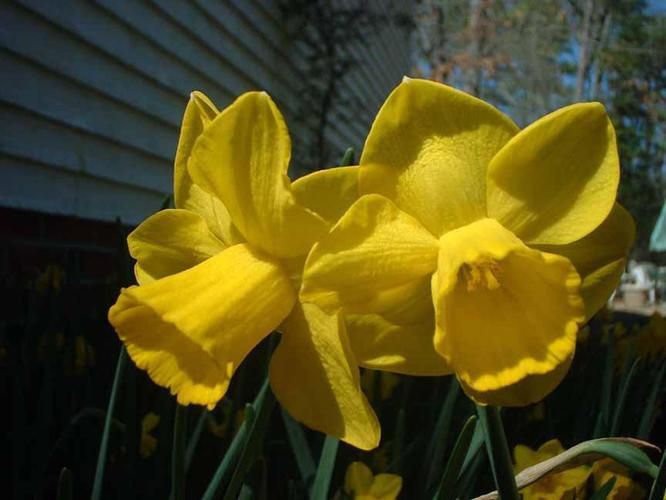

In [23]:
from PIL import Image #show a couple examples of the images (different classes)
Image.open(cwd + "/17category-flowers-py/jpg/image_0020.jpg")

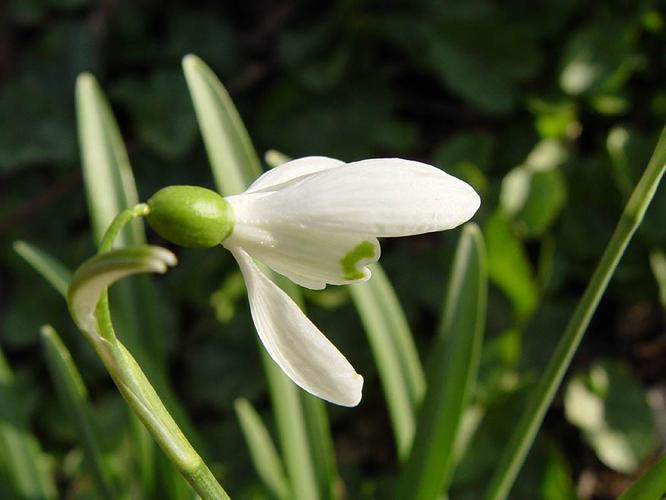

In [24]:
Image.open(cwd + "/17category-flowers-py/jpg/image_0081.jpg")

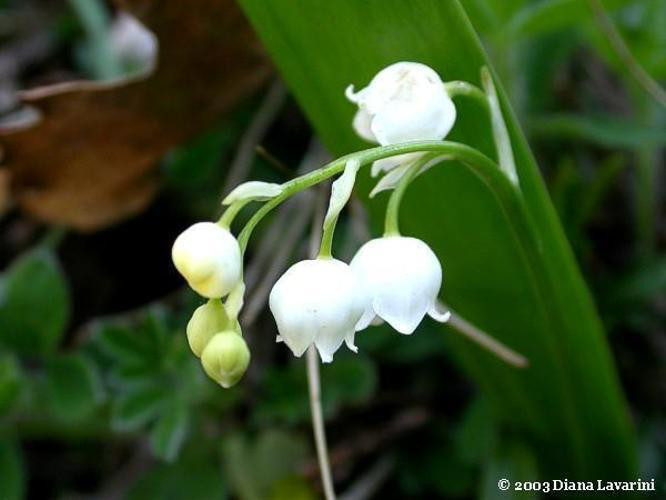

In [26]:
Image.open(cwd + "/17category-flowers-py/jpg/image_0180.jpg")

## Prepare Data for Neural Network

In [ ]:
# Data into a numpy array

def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img

images=[]
labels=[]
y=1
for i in range(1, 1361): 
    fname= cwd + "/17category-flowers-py/jpg/image_"  
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    images.append(load_data(fpath))
    labels.append(y) #labels are created as well
    if i%80==0: y+=1

images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

In [ ]:
# split data into training and test
train_images, test_images, train_labels, test_labels = train_test_split(images,labels, train_size = 0.8, random_state = 104)

# Create Train/Test Folders




## Define Data Transform and Create Data Loader

In [ ]:
# Data Transform
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
#transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Load Data into a DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size =32, shuffle=False)


In [ ]:
# Plot several figures and labels
classes = ['Daffodil','Snowdrop', 'Lily Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']

#Defines a function to display the sample images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()     # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  #transpose the numpy array to the correct dimensions and create an image using plt.show
    plt.show()              #Display Images


# get some random training images
# dataiter calls one iteration (One mini-batch) of samples from trainloader
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))


## Define the CNN

In [ ]:
#Use the nn.Module to define the Convolution Neural Network
#The Convolution Neural Network includes 2 convolution layers (with maxpool) and 3 linear fully connected layers
#Relu was used as the activation function
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()     #Inherits the attributes of the nn.Module class
        
        self.conv1 = nn.Conv2d(3, 32, 5)        #3 input image channel, 32 output channels, 5x5 square convolution
        self.pool = nn.MaxPool2d(2, 2)         #2*2 Max pooling with stride of 2
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # 5*5 from image dimension
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #Runs the input data through the network layer by layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)
print(net)

## Loss Function and Optimizer

In [ ]:
#Use the nn Module to create a Cross Entropy Loss Function
criterion = nn.CrossEntropyLoss()

#Use the torch.optim package to set up the function that updates the weights (Stochastic Gradient Descent or Adams)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001)

## Train the Network

In [ ]:
training_accuracy = []
testing_accuracy = []
train_loss = []
test_loss = []